# Imports

In [2]:

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from tqdm import tqdm

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')



/home/olga/miniconda3/envs/tabula-microcebus-v3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


scanpy==1.5.1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==1.0.5 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


## Turn on all the loggers!

In [ ]:

import logging
logger = logging.getLogger('sklearn')

logger.setLevel(logging.DEBUG)
logger = logging.getLogger('joblib')
logger.setLevel(logging.DEBUG)


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
# h5ad = '/home/olga/googledrive/.shared/Data_Analysis/Combined_Dataset/compartments_with_splicing/rijk_JO_sym-Combined-all.h5ad'
# Copied to a local directory for speed
h5ad = '/home/olga/rijk_JO_sym-Combined-all.h5ad'
# h5ad = '/home/olga/data_sm/tabula-sapiens/data-objects/rijk_JO_sym-Combined-all.h5ad'
adata = sc.read(h5ad)
adata

AnnData object with n_obs × n_vars = 114491 × 59398
    obs: '10X_barcode', '10X_replicate', '10X_run', '10X_sample', 'anatomical_position', 'barcode', 'batch', 'cell', 'cell_id', 'channel', 'compartment', 'compartment_pred', 'donor', 'donor_tech', 'donor_tech_tissue', 'manual_cell_ontology_class', 'method', 'n_counts', 'n_genes', 'notes', 'propagated_cell_ontology_class', 'sequencer', 'sex', 'smartseq2_barcode', 'smartseq2_cDNA_Plate', 'smartseq2_library_plate', 'smartseq2_sort_order', 'smartseq2_sorted_population', 'smartseq2_sorting_direction', 'smartseq2_well_seq', 'tissue'
    var: 'feature_types-0-0', 'n_cells-0-0', 'gene_symbol-0-0', 'n_cells-1-0', 'n_cells-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'n_cells-1-0-1', 'n_cells-1-1', 'n_cells', 'ensemble_id'
    obsm: 'UMAP_donor_tech.100', 'UMAP_donor_tech.200', 'UMAP_donor_tech.50', 'X_scvi', 'X_scvi_donor_tech', 'X_umap'

In [4]:
adata.var.head()

,feature_types-0-0,n_cells-0-0,gene_symbol-0-0,n_cells-1-0,n_cells-0,feature_types-0-0-1,gene_symbol-0-0-1,n_cells-1-0-1,n_cells-1-1,n_cells,ensemble_id
DDX11L1,Gene Expression,0,DDX11L1,2,2,Gene Expression,DDX11L1,21,25,50,ENSG00000223972.5
WASH7P,Gene Expression,1,WASH7P,529,529,Gene Expression,WASH7P,598,795,1946,ENSG00000227232.5
MIR6859-1,Gene Expression,0,MIR6859-1,7,7,Gene Expression,MIR6859-1,6,8,21,ENSG00000278267.1
MIR1302-2HG,Gene Expression,0,MIR1302-2HG,4,4,Gene Expression,MIR1302-2HG,7,7,19,ENSG00000243485.5
MIR1302-2,Gene Expression,0,MIR1302-2,0,0,Gene Expression,MIR1302-2,0,0,0,ENSG00000284332.1


In [5]:
adata.var.tail()

,feature_types-0-0,n_cells-0-0,gene_symbol-0-0,n_cells-1-0,n_cells-0,feature_types-0-0-1,gene_symbol-0-0-1,n_cells-1-0-1,n_cells-1-1,n_cells,ensemble_id
YBX1_splicing,Gene Expression,37746,YBX1,2462,40206,Gene Expression,YBX1,2416,2445,166933,ENSG00000065978.19
YBX3_splicing,Gene Expression,33450,YBX3,2121,35567,Gene Expression,YBX3,1699,1487,124720,ENSG00000060138.13
YWHAB_splicing,Gene Expression,33334,YWHAB,2377,35706,Gene Expression,YWHAB,2539,2745,151740,ENSG00000166913.13
ZFAS1_splicing,Gene Expression,31959,ZFAS1,1546,33505,Gene Expression,ZFAS1,1890,1984,143904,ENSG00000177410.12
ZNHIT1_splicing,Gene Expression,24158,ZNHIT1,1017,25175,Gene Expression,ZNHIT1,1081,1172,98851,ENSG00000106400.12


In [26]:
adata.obs.tissue.value_counts().sort_index()

Bladder            14054
Blood              12611
Bone_Marrow         1747
Large_Intestine     3383
Lung               21638
Lymph_Node          8890
Muscle             12965
Pancreas            4191
Small_Intestine     6698
Spleen              6776
Thymus             12263
Trachea             2941
Vasculature         6334
Name: tissue, dtype: int64

In [33]:
adata_splicing_only = adata[adata.obs.tissue == "Muscle", adata.var.index.str.endswith('_splicing')]
adata_splicing_only

View of AnnData object with n_obs × n_vars = 12965 × 528
    obs: '10X_barcode', '10X_replicate', '10X_run', '10X_sample', 'anatomical_position', 'barcode', 'batch', 'cell', 'cell_id', 'channel', 'compartment', 'compartment_pred', 'donor', 'donor_tech', 'donor_tech_tissue', 'manual_cell_ontology_class', 'method', 'n_counts', 'n_genes', 'notes', 'propagated_cell_ontology_class', 'sequencer', 'sex', 'smartseq2_barcode', 'smartseq2_cDNA_Plate', 'smartseq2_library_plate', 'smartseq2_sort_order', 'smartseq2_sorted_population', 'smartseq2_sorting_direction', 'smartseq2_well_seq', 'tissue'
    var: 'feature_types-0-0', 'n_cells-0-0', 'gene_symbol-0-0', 'n_cells-1-0', 'n_cells-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'n_cells-1-0-1', 'n_cells-1-1', 'n_cells', 'ensemble_id'
    obsm: 'UMAP_donor_tech.100', 'UMAP_donor_tech.200', 'UMAP_donor_tech.50', 'X_scvi', 'X_scvi_donor_tech', 'X_umap'

# Try using scikit learn nan pairwise distances

In [34]:

X_splicing = adata_splicing_only.X.toarray()
X_splicing

splicing_df = pd.DataFrame(X_splicing, index=adata_splicing_only.obs.index, columns=adata_splicing_only.var.index)

n_notnull = splicing_df.notnull().sum(axis=1)
n_null = splicing_df.isnull().sum(axis=1)

X_splicing_notnull = X_splicing[n_notnull > 0, :]
X_splicing_notnull.shape

(12965, 528)

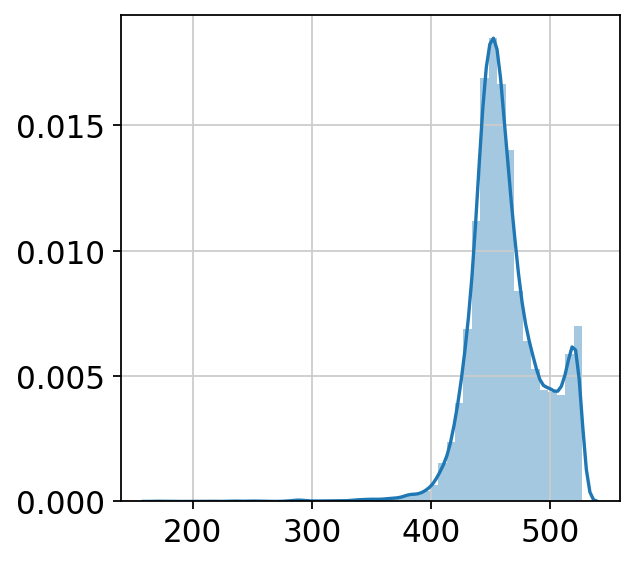

In [35]:
sns.distplot(n_null)

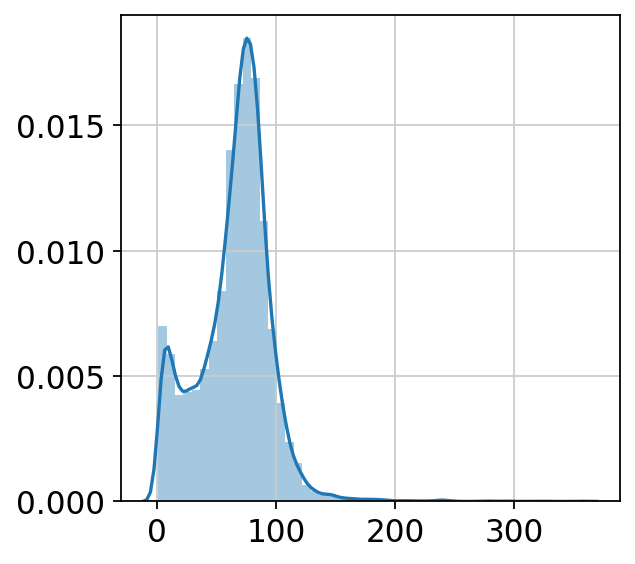

In [36]:
sns.distplot(n_notnull)

In [37]:
n_notnull 

AAACCCAGTTTACACG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    224
AAAGGGCAGATGTAGT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    139
AAAGTGAGTCATCCCT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0     76
AAATGGAGTAACAGGC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    120
AACCAACAGTAAAGCT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0     78
                                                                   ... 
TTTCACAAGTCGAAAT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-3             29
TTTCATGAGGCATCTT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-3            120
TTTGATCGTAGATTGA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-3             20
TTTGGTTAGGTTCTTG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-3             25
TTTGTTGGTTCTCTCG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-3             72
Length: 12965, dtype: int64

In [38]:
(n_notnull == 0).sum()

0

In [39]:
X_splicing.shape

(12965, 528)

In [40]:
X_splicing_notnull = X_splicing[n_notnull > 0, :]
X_splicing_notnull

array([[-0.19447996,  0.6363274 ,         nan, ...,  0.10646246,
         0.5537138 ,         nan],
       [-0.1450782 ,         nan,         nan, ...,         nan,
         0.5368404 ,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [41]:
X_splicing_notnull_subset = X_splicing_notnull[:100, :]
X_splicing_notnull_subset.shape

(100, 528)

In [42]:
# splicing_dists = nan_euclidean_distances(X_splicing)

In [43]:
def nan_euclidean_dists_arrays(X, Y, *args, **kwargs):
    dist_array = nan_euclidean_distances(X.reshape(1, -1), Y.reshape(1, -1))
    return dist_array[0][0]

### Try on a subset of 100 cells

In [49]:
%%time
splicing_dists = pairwise_distances(
    X_splicing_notnull_subset, force_all_finite=False, n_jobs=96, 
    metric=nan_euclidean_dists_arrays, verbose=True)


# splicing_dists_df = pd.DataFrame(splicing_dists, index=adata.obs.index, columns=adata.obs.index)
# splicing_dists_df.to_parquet('/home/olga/tabula_sapiens_splicing_dists.parquet')

CPU times: user 47.4 s, sys: 18.7 s, total: 1min 6s
Wall time: 47 s


In [85]:
splicing_dists

array([[2.5883205e-07, 1.4635116e+01, 1.5258859e+01, ..., 1.7399551e+01,
        1.9497406e+01, 1.6956497e+01],
       [1.4635116e+01, 2.3233770e-07, 1.4891888e+01, ..., 1.5042525e+01,
        2.2320271e+01, 1.8642029e+01],
       [1.5258859e+01, 1.4891888e+01, 0.0000000e+00, ..., 1.3291699e+01,
        2.2997435e+01, 1.4510878e+01],
       ...,
       [1.7399551e+01, 1.5042526e+01, 1.3291699e+01, ..., 0.0000000e+00,
        2.3260384e+01, 1.1212463e+01],
       [1.9497408e+01, 2.2320272e+01, 2.2997435e+01, ..., 2.3260384e+01,
        1.9369216e-07, 1.7260548e+01],
       [1.6956497e+01, 1.8642029e+01, 1.4510878e+01, ..., 1.1212463e+01,
        1.7260548e+01, 0.0000000e+00]], dtype=float32)

In [86]:
X_splicing_notnull_subset.shape

(100, 528)

In [50]:
X_splicing_notnull.shape

(12965, 528)

### How long for full muscle data?

In [51]:
(17.5 * X_splicing_notnull.shape[0]/100)/60

37.81458333333333

#### --> 37 min

## Try on just the muscle data

In [ ]:
%%time
splicing_dists = pairwise_distances(
    X_splicing_notnull, force_all_finite=False, n_jobs=96, 
    metric=nan_euclidean_dists_arrays, verbose=True)


In [ ]:
2+2

In [ ]:
generator = pairwise_distances_chunked(X_splicing_notnull, force_all_finite=False, n_jobs=96, 
    metric=nan_euclidean_dists_arrays, verbose=True, working_memory=100)

n_cells = X_splicing_notnull.shape[0]


splicing_dists = np.zeros((n_cells, n_cells))

for i, g in tqdm(enumerate(generator)):
    splicing_dists[i, :] = g

## Try scipy spatial distandce

In [55]:
2+2

4

In [58]:
splicing_dists.shape

(12965, 12965)

In [56]:
splicing_dists

array([[2.5883205e-07, 1.4635116e+01, 1.5258859e+01, ..., 1.7399551e+01,
        1.9497406e+01, 1.6956497e+01],
       [1.4635116e+01, 2.3233770e-07, 1.4891888e+01, ..., 1.5042525e+01,
        2.2320271e+01, 1.8642029e+01],
       [1.5258859e+01, 1.4891888e+01, 0.0000000e+00, ..., 1.3291699e+01,
        2.2997435e+01, 1.4510878e+01],
       ...,
       [1.7399551e+01, 1.5042526e+01, 1.3291699e+01, ..., 0.0000000e+00,
        2.3260384e+01, 1.1212463e+01],
       [1.9497408e+01, 2.2320272e+01, 2.2997435e+01, ..., 2.3260384e+01,
        1.9369216e-07, 1.7260548e+01],
       [1.6956497e+01, 1.8642029e+01, 1.4510878e+01, ..., 1.1212463e+01,
        1.7260548e+01, 0.0000000e+00]], dtype=float32)

## Write my own nan euclidean distances

In [82]:
def my_nan_euclidean_metric(row_i, row_j):
    assert row_i.shape == row_j.shape
    
    i_missing = np.isnan(row_i)
    j_missing = np.isnan(row_j)
    
    shared = (~i_missing) & (~j_missing)
    weight = row_i.shape[0] / shared.sum()
    
    i_shared = row_i[shared]
    j_shared = row_j[shared]
    
    sum_of_squares = np.sum(np.square(i_shared - j_shared))
    distance = np.sqrt(weight * sum_of_squares)
    return distance

In [83]:
%timeit my_nan_euclidean_metric(row_i, row_j)

26.1 µs ± 282 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
row_i = X_splicing_notnull[0, :]
row_j = X_splicing_notnull[1, :]

In [80]:
%timeit nan_euclidean_dists_arrays(row_i, row_j)

348 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [81]:
%timeit my_nan_euclidean_metric(row_i, row_j)

25.6 µs ± 428 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
my_nan_euclidean_metric

## Do multiprocessing simliarity

In [99]:
import itertools
from functools import partial
import multiprocessing
import tempfile
import time

import numpy as np
from sourmash.logging import notify


def my_nan_euclidean_metric(row_i, row_j):
    #     assert row_i.shape == row_j.shape

    i_missing = np.isnan(row_i)
    j_missing = np.isnan(row_j)

    shared = (~i_missing) & (~j_missing)
    n_shared = shared.sum()
    if n_shared == 0:
        return 0
    weight = row_i.shape[0] / n_shared

    i_shared = row_i[shared]
    j_shared = row_j[shared]

    sum_of_squares = np.sum(np.square(i_shared - j_shared))
    distance = np.sqrt(weight * sum_of_squares)
    return distance


def to_memmap(array):
    """Write a memory mapped array
    Create a memory-map to an array stored in a binary file on disk.
    Memory-mapped files are used for accessing small segments of
    large files on disk, without reading the entire file into memory.
    :param np.array array to memory map
    :return: np.array large_memmap memory mapped array
    :return: str filename name of the file that memory mapped array is written to
    """
    import numpy as np

    filename = tempfile.NamedTemporaryFile(
        prefix="array", suffix=".mmap", delete=False
    ).name
    shape = array.shape
    f = np.memmap(filename, mode="w+", shape=shape, dtype=array.dtype)
    f[:] = array[:]
    del f
    large_memmap = np.memmap(filename, dtype=array.dtype, shape=shape)
    return large_memmap, filename


def distance_args_unpack(args):
    """Helper function to unpack the arguments. Written to use in pool.imap
    as it can only be given one argument."""
    row_i, row_j = args
    return my_nan_euclidean_metric(row_i, row_j)


def get_distances_at_index(index, matrix):
    """Returns similarities of all the combinations of signature at index in
    the siglist with the rest of the indices starting at index + 1. Doesn't
    redundantly calculate signatures with all the other indices prior to
    index - 1

    :param int index: generate masks from this image
    :param boolean ignore_abundance
        If the sketches are not abundance weighted, or ignore_abundance=True,
        compute Jaccard similarity.

        If the sketches are abundance weighted, calculate the angular
        similarity.
    :param boolean downsample by max_hash if True
    :param siglist list of signatures
    :return: list of similarities for the combinations of signature at index
        with rest of the signatures from index+1
    """
    startt = time.time()
    sig_iterator = itertools.product([matrix[index, :]], matrix[(index + 1) :, :])
    func = partial(distance_args_unpack,)
    similarity_list = list(map(func, sig_iterator))
    notify(
        "comparison for index {} done in {:.5f} seconds",
        index,
        time.time() - startt,
        end="\r",
    )
    return similarity_list


def distances_parallel(matrix, n_jobs):
    """Compare all combinations of signatures and return a matrix
    of similarities. Processes combinations parallely on number of processes
    given by n_jobs

    :param list siglist: list of signatures to compare
    :param boolean ignore_abundance
        If the sketches are not abundance weighted, or ignore_abundance=True,
        compute Jaccard similarity.

        If the sketches are abundance weighted, calculate the angular
        similarity.
    :param boolean downsample by max_hash if True
    :param int n_jobs number of processes to run the similarity calculations on
    :return: np.array similarity matrix
    """

    # Starting time - calculate time to keep track in case of lengthy siglist
    start_initial = time.time()

    # Create a memory map of the siglist using numpy to avoid memory burden
    # while accessing small parts in it
    matrix, _ = to_memmap(np.array(matrix))
    notify("Created memmapped siglist")

    # Check that length of combinations can result in a square similarity matrix
    length_matrix = len(matrix)
    shape = (length_matrix, length_matrix)

    # Initialize with ones in the diagonal as the similarity of a signature with
    # itself is one
    distances = np.zeros(shape, dtype=np.float64)
    memmap_distances, filename = to_memmap(distances)
    notify("Initialized memmapped similarities matrix")

    # Initialize the function using func.partial with the common arguments like
    # siglist, ignore_abundance, downsample, for computing all the signatures
    # The only changing parameter that will be mapped from the pool is the index
    func = partial(get_distances_at_index, matrix=matrix,)
    notify("Created similarity func")

    # Initialize multiprocess.pool
    pool = multiprocessing.Pool(processes=n_jobs)

    # Calculate chunk size, by default pool.imap chunk size is 1
    chunksize, extra = divmod(length_matrix, n_jobs)
    if extra:
        chunksize += 1
    notify("Calculated chunk size for multiprocessing")

    # This will not generate the results yet, since pool.imap returns a generator
    result = pool.imap(func, range(length_matrix), chunksize=chunksize)
    notify("Initialized multiprocessing pool.imap")

    # Enumerate and calculate similarities at each of the indices
    # and set the results at the appropriate combination coordinate
    # locations inside the similarity matrix
    for index, l in enumerate(result):
        startt = time.time()
        col_idx = index + 1
        for idx_condensed, item in enumerate(l):
            i = index
            j = col_idx + idx_condensed
            memmap_distances[i, j] = memmap_distances[j, i] = item
        notify(
            "Setting similarities matrix for index {} done in {:.5f} seconds",
            index,
            time.time() - startt,
            end="\r",
        )
    notify("Setting similarities completed")

    pool.close()
    pool.join()

    notify(
        "Time taken to compare all pairs parallely is {:.5f} seconds ",
        time.time() - start_initial,
    )
    return np.memmap(filename, dtype=np.float64, shape=shape)


In [98]:
%%time
distances_parallel(X_splicing_notnull_subset, n_jobs=32)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
/home/olga/miniconda3/envs/tabula-microcebus-v3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in long_scalars
/home/olga/miniconda3/envs/tabula-microcebus-v3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
Calculated chunk size for multiprocessingeconds
Initialized multiprocessing pool.imap
Setting similarities completedr index 99 done in 0.00000 seconds


CPU times: user 0 ns, sys: 54.1 s, total: 54.1 s
Wall time: 1min 1s


Time taken to compare all pairs parallely is 61.68402 seconds 


memmap([[ 0.        , 14.63511684, 15.25885978, ..., 15.35303398,
         14.28183881, 12.78772027],
        [14.63511684,  0.        , 14.89188869, ..., 12.87287525,
         14.47829297, 13.5172811 ],
        [15.25885978, 14.89188869,  0.        , ..., 13.79516365,
         15.30513076, 13.23647581],
        ...,
        [15.35303398, 12.87287525, 13.79516365, ...,  0.        ,
         13.66651696,  9.71113195],
        [14.28183881, 14.47829297, 15.30513076, ..., 13.66651696,
          0.        , 14.51177185],
        [12.78772027, 13.5172811 , 13.23647581, ...,  9.71113195,
         14.51177185,  0.        ]])

# Read parquet files

In [54]:
parquet_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-08-20'
! ls -lha $parquet_folder

total 7.2G
drwxr-xr-x 2 olga czb 4.0K Aug 20 16:28 .
drwxr-xr-x 3 olga czb 4.0K Aug 20 16:25 ..
-rw-r--r-- 1 olga czb 546M Aug 20 16:27 lemur_Bernard_4_sym_S_0.1_z_0.0001_b_0.pq
-rw-r--r-- 1 olga czb 583M Aug 20 16:28 lemur_Martine_4_sym_S_0.1_z_0.0001_b_0.pq
-rw-r--r-- 1 olga czb 243K Aug 20 16:28 test_sym_S_0.1_z_0.0001_b_0.pq
-rw-r--r-- 1 olga czb 3.0G Aug 20 16:27 TS_10x_redo_sym_S_0.1_z_0.0001_b_0.pq
-rw-r--r-- 1 olga czb 2.8G Aug 20 16:26 TSP1_SS2_sym_S_0.1_z_0.0001_b_0.pq
-rw-r--r-- 1 olga czb 352M Aug 20 16:26 TSP2_10x_rerun_5prime_sym_S_0.1_z_0.0001_b_0.pq


In [59]:
pd.options.display.max_columns = 100

In [ ]:
adata.obs.head()

In [ ]:
def process_splicing(filename):
    splicing_df = pd.read_parquet(f'{parquet_folder}/TS_10x_redo_sym_S_0.1_z_0.0001_b_0.pq')
    
    # Drop duplicate cell ids and gene names
    splicing_df_no_dups = splicing_df.drop_duplicates(['cell', 'geneR1B_uniq'])
    
    # Don't use rows with empty gene names -- these are unannotated genes
    splicing_df_no_dups = splicing_df_no_dups.query('geneR1B_uniq != ""')
    print(splicing_df_no_dups.shape)
    splicing_df_no_dups.head()
    
    splicing2d = splicing_df_no_dups.pivot(index='cell', columns='geneR1B_uniq', values='z')
    return splicing2d

In [57]:
sapiens_10x_redo = pd.read_parquet(f'{parquet_folder}/TS_10x_redo_sym_S_0.1_z_0.0001_b_0.pq')
print(sapiens_10x_redo.shape)
sapiens_10x_redo.head()

(63218627, 71)


,inc_emp.p,tissue,gene_count_per_cell_filt,juncPosR1A,geneR1A_uniq,juncPosR1B,numReads,cell,channel,splice_ann,...,cov,z,cov_ann,z_ann,cov_dom_ch,z_dom_ch,cov_unann,z_unann,cov_dom_unch,z_dom_unch
0,True,Pancreas,12.0,89572278.0,SLC16A12,89534434.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,...,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
1,True,Pancreas,12.0,89572278.0,SLC16A12,89534434.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,...,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
2,True,Pancreas,1.0,89535684.0,SLC16A12,89512143.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,...,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
3,True,Pancreas,1.0,89535684.0,SLC16A12,89512143.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,...,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
4,True,Pancreas,1.0,26765218.0,ABI1,26751783.0,1.0,TSP1_exopancreas2_3_S6_L00_GTAACCACACAATGTC,TSP1_exopancreas2_3_S6_L00,True,...,-0.001882,0.266201,-0.001882,0.266201,-0.01519,NaN,NaN,NaN,0.000620,0.263699


In [60]:
sapiens_10x_redo.head()

,inc_emp.p,tissue,gene_count_per_cell_filt,juncPosR1A,geneR1A_uniq,juncPosR1B,numReads,cell,channel,splice_ann,compartment,free_annotation,missing_domains,domain_insertions,refName_newR1,gene_frac_filt,geneR1B_uniq,sign,posA_group,posB_group,rank_acc,rank_don,max_rank_acc,max_rank_don,num_missing_A,num_inserted_A,domain_changed_A,num_missing_B,num_inserted_B,domain_changed_B,max_rank,sum_reads_group,read_x_acc,rank_mean,sq_diff,don_num,don_sigma,S_ijk_A,S_ijk_A_unpinned,n_sijk,cell_gene,x_sijk,z_A,idxmax_z,junc_max_A,max_don_z_A,num_dom_ch,z_A_ann,z_A_dom_ch,num_dom_unch,z_A_unann,z_A_dom_unch,S_ijk_B,S_ijk_B_unpinned,z_B,junc_max_B,max_don_z_B,z_B_ann,z_B_dom_ch,z_B_unann,z_B_dom_unch,cov,z,cov_ann,z_ann,cov_dom_ch,z_dom_ch,cov_unann,z_unann,cov_dom_unch,z_dom_unch
0,True,Pancreas,12.0,89572278.0,SLC16A12,89534434.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,Epithelial,pancreatic D cell,None,None,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.083333,SLC16A12,-1.0,89572278SLC16A12,89534434SLC16A12,1.0,2.0,2.0,2.0,0.0,0.0,False,0.0,0.0,False,2.0,10.0,1.0,1.500000,0.250000,2.500000,0.277778,-0.199713,-0.948683,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTTSLC...,-0.199713,0.163858,154.0,chr10::89572278:-|chr10:SLC16A12:89534434:-,-0.141219,NaN,NaN,NaN,-0.231730,0.163858,0.163858,0.17409,1.959592,-0.246201,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.12310,NaN,NaN,-0.246201,-0.246201,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
1,True,Pancreas,12.0,89572278.0,SLC16A12,89534434.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,Epithelial,pancreatic D cell,None,None,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.083333,SLC16A12,-1.0,89572278SLC16A12,89534434SLC16A12,1.0,2.0,2.0,2.0,0.0,0.0,False,0.0,0.0,False,2.0,10.0,1.0,1.500000,0.250000,2.500000,0.277778,-0.199713,-0.948683,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTTSLC...,-0.199713,0.163858,154.0,chr10::89572278:-|chr10:SLC16A12:89534434:-,-0.141219,NaN,NaN,NaN,-0.231730,0.163858,0.163858,0.17409,1.095426,-0.246201,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.12310,NaN,NaN,-0.246201,-0.246201,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
2,True,Pancreas,1.0,89535684.0,SLC16A12,89512143.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,Epithelial,pancreatic D cell,None,None,chr10:SLC16A12:89535684:-|chr10:SLC16A12:89512...,1.000000,SLC16A12,-1.0,89535684SLC16A12,89512143SLC16A12,2.0,4.0,3.0,4.0,0.0,0.0,False,0.0,0.0,False,3.0,185.0,2.0,2.021622,0.000467,83.913514,0.456052,-0.032017,-0.032017,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTTSLC...,-0.032017,0.163858,154.0,chr10::89572278:-|chr10:SLC16A12:89534434:-,-0.141219,NaN,NaN,NaN,-0.231730,0.163858,0.163858,0.17409,1.959592,-0.246201,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.12310,NaN,NaN,-0.246201,-0.246201,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
3,True,Pancreas,1.0,89535684.0,SLC16A12,89512143.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,Epithelial,pancreatic D cell,None,None,chr10:SLC16A12:89535684:-|chr10:SLC16A12:89512...,1.000000,SLC16A12,-1.0,89535684SLC16A12,89512143SLC16A12,2.0,4.0,3.0,4.0,0.0,0.0,False,0.0,0.0,False,3.0,185.0,2.0,2.021622,0.000467,83.913514,0.456052,-0.032017,-0.032017,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTTSLC...,-0.032017,0.163858,154.0,chr10::89572278:-|chr10:SLC16A12:89534434:-,-0.141219,NaN,NaN,NaN,-0.231730,0.163858,0.163858,0.17409,1.095426,-0.246201,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.12310,NaN,NaN,-0.246201,-0.246201,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
4,True,Pancreas,1.0,26765218.0,ABI1,26751783.0,1.0,TSP1_exopancreas2_3_S6_L00_GTAACCACACAATGTC,TSP1_exopancreas2_3_S6_L00,True,Epithelial,pancreatic acinar cell,None,None,chr10:ABI1:26765218:-|chr10:ABI1:26751783:-,1.000000,ABI1,-1.0

In [90]:
sapiens_10x_redo_nodups = sapiens_10x_redo.drop_duplicates(['cell', 'geneR1B_uniq'])
# Don't use rows with empty gene names -- these are unannotated genes
sapiens_10x_redo_nodups = sapiens_10x_redo_nodups.query('geneR1B_uniq != ""')
print(sapiens_10x_redo_nodups.shape)
sapiens_10x_redo_nodups.head()

(23330063, 71)


,inc_emp.p,tissue,gene_count_per_cell_filt,juncPosR1A,geneR1A_uniq,juncPosR1B,numReads,cell,channel,splice_ann,compartment,free_annotation,missing_domains,domain_insertions,refName_newR1,gene_frac_filt,geneR1B_uniq,sign,posA_group,posB_group,rank_acc,rank_don,max_rank_acc,max_rank_don,num_missing_A,num_inserted_A,domain_changed_A,num_missing_B,num_inserted_B,domain_changed_B,max_rank,sum_reads_group,read_x_acc,rank_mean,sq_diff,don_num,don_sigma,S_ijk_A,S_ijk_A_unpinned,n_sijk,cell_gene,x_sijk,z_A,idxmax_z,junc_max_A,max_don_z_A,num_dom_ch,z_A_ann,z_A_dom_ch,num_dom_unch,z_A_unann,z_A_dom_unch,S_ijk_B,S_ijk_B_unpinned,z_B,junc_max_B,max_don_z_B,z_B_ann,z_B_dom_ch,z_B_unann,z_B_dom_unch,cov,z,cov_ann,z_ann,cov_dom_ch,z_dom_ch,cov_unann,z_unann,cov_dom_unch,z_dom_unch
0,True,Pancreas,12.0,89572278.0,SLC16A12,89534434.0,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTT,TSP1_exopancreas2_3_S6_L00,False,Epithelial,pancreatic D cell,None,None,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.083333,SLC16A12,-1.0,89572278SLC16A12,89534434SLC16A12,1.0,2.0,2.0,2.0,0.0,0.0,False,0.0,0.0,False,2.0,10.0,1.0,1.500000,0.250000,2.500000,0.277778,-0.199713,-0.948683,1.0,TSP1_exopancreas2_3_S6_L00_TCTGCCATCCATACTTSLC...,-0.199713,0.163858,154.0,chr10::89572278:-|chr10:SLC16A12:89534434:-,-0.141219,NaN,NaN,NaN,-0.231730,0.163858,0.163858,0.174090,1.959592,-0.246201,chr10::89572278:-|chr10:SLC16A12:89534434:-,0.123100,NaN,NaN,-0.246201,-0.246201,-0.005422,0.295378,-0.010067,NaN,NaN,NaN,0.002585,0.287371,-0.005422,0.295378
4,True,Pancreas,1.0,26765218.0,ABI1,26751783.0,1.0,TSP1_exopancreas2_3_S6_L00_GTAACCACACAATGTC,TSP1_exopancreas2_3_S6_L00,True,Epithelial,pancreatic acinar cell,None,None,chr10:ABI1:26765218:-|chr10:ABI1:26751783:-,1.000000,ABI1,-1.0,26765218ABI1,26751783ABI1,1.0,3.0,4.0,3.0,0.0,0.0,False,0.0,0.0,False,4.0,86.0,1.0,2.081395,1.169416,116.430233,1.369767,-0.199713,-0.923977,1.0,TSP1_exopancreas2_3_S6_L00_GTAACCACACAATGTCABI1,-0.199713,0.199713,303.0,chr10:ABI1:26765218:-|chr10:ABI1:26751783:-,-0.199713,NaN,0.199713,NaN,-0.199713,NaN,0.199713,0.174090,0.898933,-0.174090,chr10:ABI1:26765218:-|chr10:ABI1:26751783:-,0.174090,-0.174090,NaN,NaN,-0.174090,-0.001882,0.266201,-0.001882,0.266201,-0.01519,NaN,NaN,NaN,0.000620,0.263699
5,True,Pancreas,1.0,26777065.0,ABI1,26770345.0,1.0,TSP1_exopancreas2_3_S6_L00_GTTAGTGCACTCATAG,TSP1_exopancreas2_3_S6_L00,True,Epithelial,pancreatic ductal cell,Abi_HHR,None,chr10:ABI1:26777065:-|chr10:ABI1:26770345:-,1.000000,ABI1,-1.0,26777065ABI1,26770345ABI1,1.0,2.0,2.0,2.0,1.0,0.0,True,1.0,0.0,True,2.0,100.0,1.0,1.410000,0.168100,24.190000,0.244343,-0.199713,-0.829437,1.0,TSP1_exopancreas2_3_S6_L00_GTTAGTGCACTCATAGABI1,-0.199713,0.199713,305.0,chr10:ABI1:26777065:-|chr10:ABI1:26770345:-,-0.199713,-0.199713,0.199713,0.199713,NaN,NaN,NaN,0.174090,0.578526,-0.174090,chr10:ABI1:26777065:-|chr10:ABI1:26770345:-,0.174090,-0.174090,-0.17409,NaN,NaN,-0.001882,0.266201,-0.001882,0.266201,-0.01519,0.279509,NaN,NaN,0.000620,NaN
6,True,Pancreas,1.0,26860747.0,ABI1,26823305.0,1.0,TSP1_exopancreas2_3_S6_L00_AACAACCGTAGCACAG,TSP1_exopancreas2_3_S6_L00,True,Epithelial,pancreatic acinar cell,None,None,chr10:ABI1:26860747:-|chr10:ABI1:26823305:-,1.000000,ABI1,-1.0,26860747ABI1,26823305ABI1,1.0,2.0,2.0,2.0,0.0,0.0,False,0.0,0.0,False,2.0,420.0,1.0,1.007143,0.000051,2.978571,0.007109,-0.084718,-0.084718,1.0,TSP1_exopancreas2_3_S6_L00_AACAACCGTAGCACAGABI1,-0.084718,0.084718,307.0,chr10:ABI1:26860747:-|chr10:ABI1:26823305:-,-0.084718,NaN,0.084718,NaN,-0.084718,NaN,0.084718,0.109371,0.109371,-0.109371,chr10:ABI1:26860747:-|chr10:ABI1:26823305:-,0.109371,-0.109371,NaN,NaN,-0.109371,-0.001882,0.139124,-0.001882,0.139124,-0.01519,NaN,NaN,NaN,0.000620,0.136621
7,True,Pancreas,1.0,26860747.0,ABI1,26823305.0,1.0,TSP1_exopancreas2_3_S6_L00_AGACAGGGTAGCTCGC,TSP1_exopancreas2_3_S6_L00,True,Epithelial,pancreatic acinar cell,None,None,chr10:ABI1:26860747:-|chr10:ABI1:26823305:-,1.000000,ABI1,-1.0,26860747ABI1,26823305ABI1,1.0,2.0,2.0,2.0,0.0,0.

In [91]:
sapiens10x_2d = sapiens_10x_redo_nodups.pivot(index='cell', columns='geneR1B_uniq', values='z')
print(sapiens10x_2d.shape)
sapiens10x_2d.head()

(32063, 12101)


geneR1B_uniq,A1BG-AS1,A1CF,A2M,A2ML1-AS1,A4GALT,AAAS,AADACP1,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,AARSD1,AASDH,AASDHPPT,AASS,ABALON,ABAT,ABCA1,ABCA10,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB4,ABCB7,ABCB8,ABCC2,ABCC3,ABCC4,ABCC5,ABCC9,ABCD3,ABCE1,ABCF2,ABCG1,ABHD11,ABHD11-AS1,ABHD12,ABHD14A-ACY1,ABHD14B,ABHD16B,ABHD17A,ABHD17C,ABHD2,...,ZNF816,ZNF821,ZNF826P,ZNF83,ZNF830,ZNF836,ZNF837,ZNF84,ZNF841,ZNF846,ZNF85,ZNF852,ZNF879,ZNF880,ZNF890P,ZNF891,ZNF90,ZNF91,ZNF92,ZNF98,ZNFX1,ZNHIT1,ZNHIT6,ZNRF1,ZNRF2,ZRANB1,ZRANB2,ZRANB2-AS2,ZRANB3,ZRSR2,ZSCAN16,ZSCAN16-AS1,ZSCAN2,ZSCAN21,ZSCAN4,ZSCAN5A,ZSWIM4,ZSWIM6,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZYG11A,ZYX,ZZEF1,ZZZ3,bP-2189O9.2,hsa-mir-3179-1,pk,unknown
cell,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSP1_bladder_1_S7_L00_AAACCCATCCTTCGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099724
TSP1_bladder_1_S7_L00_AAACCCATCGAAGGAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.161131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.174090
TSP1_bladder_1_S7_L00_AAACGAAGTGAGTAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.026689,NaN,NaN,NaN,NaN,-0.022283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282437
TSP1_bladder_1_S7_L00_AAACGCTAGCACGGAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.037744,NaN,NaN,NaN,NaN,0.029579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.039916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007269
TSP1_bladder_1_S7_L00_AAACGCTGTACCGGCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.18437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020425,NaN,NaN,NaN,NaN,NaN,-0.177911,NaN,NaN,-0.033389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.055802


In [92]:
sapiens10x_2d.iloc[:5, :5]

geneR1B_uniq,A1BG-AS1,A1CF,A2M,A2ML1-AS1,A4GALT
cell,,,,,
TSP1_bladder_1_S7_L00_AAACCCATCCTTCGAC,NaN,NaN,NaN,NaN,NaN
TSP1_bladder_1_S7_L00_AAACCCATCGAAGGAC,NaN,NaN,NaN,NaN,NaN
TSP1_bladder_1_S7_L00_AAACGAAGTGAGTAAT,NaN,NaN,NaN,NaN,NaN
TSP1_bladder_1_S7_L00_AAACGCTAGCACGGAT,NaN,NaN,NaN,NaN,NaN
TSP1_bladder_1_S7_L00_AAACGCTGTACCGGCT,NaN,NaN,NaN,NaN,NaN


In [93]:
sapiens10x_2d.iloc[:5, :5].columns.values

array(['A1BG-AS1', 'A1CF', 'A2M', 'A2ML1-AS1', 'A4GALT'], dtype=object)

## Run parallel distances on it

In [ ]:
%%time
sapiens10x_distances = distances_parallel(X_splicing_notnull, n_jobs=96)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Exception ignored in: <function _releaseLock at 0x7f183b939840>
Traceback (most recent call last):
  File "/home/olga/miniconda3/envs/tabula-microcebus-v3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
